In [1]:
import pandas as pd
import numpy as np
import csv as csv
from datetime import *
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
import random
from scipy.stats import mode
from collections import Counter  
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, StratifiedKFold
%matplotlib inline

In [30]:
# 导入数据
df = pd.read_table('./data/oppo_round1_train_20180929.txt', 
                   names= ['prefix','query_prediction','title','tag','label'], header=None, na_values='', keep_default_na=False, encoding='utf-8', quoting=3)
print(df.info())
print(df.head())
validDf = pd.read_table('./data/oppo_round1_vali_20180929.txt', 
                        names = ['prefix','query_prediction','title','tag','label'], header=None, na_values='', keep_default_na=False, encoding='utf-8', quoting=3)
predictDf = pd.read_table('./data/oppo_round1_test_A_20180929.txt', 
                        names = ['prefix','query_prediction','title','tag','label'], header=None, na_values='', keep_default_na=False, encoding='utf-8', quoting=3)
print(validDf.info())
print(predictDf.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000000 entries, 0 to 1999999
Data columns (total 5 columns):
prefix              object
query_prediction    object
title               object
tag                 object
label               int64
dtypes: int64(1), object(4)
memory usage: 76.3+ MB
None
  prefix                                   query_prediction            title  \
0     小品  {"小品大全宋小宝": "0.009", "小品相亲": "0.012", "小品剧本": ...               小品   
1   1368  {"13688cc赛马会": "0.059", "13685367892": "0.124"...  HCG大于1368%2C正常吗   
2   1368  {"13688cc赛马会": "0.059", "13685367892": "0.124"...            1368年   
3     银耳  {"银耳汤的功效": "0.012", "银耳为什么不能天天吃": "0.009", "银耳...         银耳红枣汤的做法   
4   月经量少  {"月经量少喝红糖水好吗": "0.010", "月经量少该怎么调理": "0.016", ...         月经量少怎么调理   

  tag  label  
0  阅读      0  
1  健康      0  
2  百科      1  
3  菜谱      1  
4  百科      0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 5 columns):
prefix             

In [2]:
# 统计训练集空缺值情况(采用原先的默认读取方法)
print(df.count())
df[df.prefix.isnull()]

D:\Program Files (x86)\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2723: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


prefix              1999995
query_prediction    1999999
title               1999999
tag                 1999999
label               1999999
dtype: int64


prefix                                   query_prediction  \
180026    NaN  {"null是什么梗": "0.007", "null中文什么意思": "0.010", "...   
180027    NaN  {"null是什么梗": "0.007", "null中文什么意思": "0.010", "...   
180029    NaN  {"null是什么梗": "0.007", "null中文什么意思": "0.010", "...   
180031    NaN  {"null是什么梗": "0.007", "null中文什么意思": "0.010", "...   

                        title tag label  
180026  outro＊liberalist-Null  音乐     0  
180027           我在你的家里面.null  音乐     0  
180029          圣母颂(舒伯特).null  音乐     0  
180031                   Null  百科     0

**preifx的空缺值也是有意义的，属于误判**

*（此处采用的是原默认参数的读取函数，改进后的读取方案见上一个cell的导入）*

In [11]:
# 功能函数

# 矩估计法计算贝叶斯平滑参数
def countBetaParamByMME(inputArr, epsilon=0):
    EX = inputArr.mean()
    DX = inputArr.var() + epsilon / len(inputArr)  # 加上极小值防止除以0
    alpha = (EX*(1-EX)/DX - 1) * EX
    beta = (EX*(1-EX)/DX - 1) * (1-EX)
    return alpha,beta

# 对numpy数组进行贝叶斯平滑处理
def biasSmooth(aArr, bArr, method='MME', epsilon=0, alpha=None, beta=None):
    ratioArr = aArr / bArr
    if method=='MME':
        if len(ratioArr[ratioArr==ratioArr]) > 1:
            alpha,beta = countBetaParamByMME(ratioArr[ratioArr==ratioArr], epsilon=epsilon)
        else:
            alpha = beta = 0
        # print(alpha+beta, alpha / (alpha+beta))
    resultArr = (aArr+alpha) / (bArr+alpha+beta)
    return resultArr


In [6]:
# 统计特征函数
def formatQuery(df):
    '''
    格式化预测词字段
    '''
    tempDf = df[['prefix','query_prediction']].drop_duplicates(subset='prefix')
    def format(x):
        x = eval(x)
        x = {k:float(v) for k,v in x.items()}
        return x
    tempDf['query_prediction'] = tempDf['query_prediction'].dropna().map(lambda x: format(x))
    tempDf['query_predict_num'] = tempDf['query_prediction'].dropna().map(lambda x: len(x))
    tempDf.loc[tempDf.query_predict_num==0, 'query_prediction'] = np.nan
    tempDf['query_predict_num'].fillna(0, inplace=True)
    tempDf['query_word'] = tempDf['query_prediction'].dropna().map(lambda x: list(x.keys()))
    tempDf['query_ratio'] = tempDf['query_prediction'].dropna().map(lambda x: list(x.values()))
    df = df.drop(['query_prediction'], axis=1).merge(tempDf, how='left', on=['prefix'])
    return df

def addCrossColNunique(df, statDf, col1, col2, alias=None):
    '''
    统计每个col1中col2的种类数
    '''
    if alias is None:
        alias = '%s_%s' % (col1, col2)
    if '%s_nunique'%alias in statDf.columns:
        tempDf = statDf[[col1, '%s_nunique'%alias]].drop_duplicates(subset=col1)
        df = df.merge(tempDf, how='left', on=col1)
    else:
        tempDf = statDf.groupby(col1)[col2].nunique().to_frame()
        tempDf.columns = ['%s_nunique'%alias]
        df = df.merge(tempDf.reset_index(), how='left', on=col1)
    return df

def addLabelFea(df, statDf, colArr, alias=None):
    '''
    统计列的标签独立数和标签点击率
    '''
    if len(np.array(colArr).shape) == 0:
        colArr = [colArr]
    if alias is None:
        alias = '_'.join(np.array(colArr).astype(str))
    if statDf[colArr].count().min() == 0:
        df['%s_label_len'%alias] = df['%s_label_sum'%alias] = 0
        df['%s_label_ratio'%alias] = df['%s_label_ratio2'%alias] = np.nan
        return df
    if '%s_label_ratio'%alias in statDf.columns:
        tempDf = statDf[colArr + ['%s_label_len'%alias, '%s_label_sum'%alias, '%s_label_ratio'%alias, '%s_label_ratio2'%alias]].drop_duplicates(subset=colArr)
        df = df.merge(tempDf, how='left', on=colArr)
        df.fillna({'%s_label_len'%alias: 0, '%s_label_sum'%alias: 0}, inplace=True)
    else:
        tempDf = statDf.groupby(colArr)['label'].agg([len, 'sum'])
        tempDf['ratio'] = biasSmooth(tempDf['sum'], tempDf['len'])
        tempDf['ratio2'] = tempDf['sum'] / tempDf['len']
        tempDf.loc[:,['len','sum']] /= tempDf[['len','sum']].sum()
        tempDf.columns = ['%s_label_%s'%(alias,x) for x in tempDf.columns]
        df = df.merge(tempDf.reset_index(), 'left', on=colArr)
        df.fillna({'%s_label_len'%alias: 0, '%s_label_sum'%alias: 0}, inplace=True)
    return df

def addNewValFea(df, statDf, cols):
    '''
    判断字段值是否在统计表中出现过
    '''
    if len(np.array(cols).shape) == 0:
        cols = [cols]
    for col in cols:
        if statDf[col].count() == 0:
            df['%s_newVal'%col] = 1
        else:
            tempDf = df[[col]].drop_duplicates()
            existList = np.intersect1d(tempDf[col].dropna(),statDf[col].dropna())
            tempDf['%s_newVal'%col] = (~tempDf[col].isin(existList)).astype(int)
            df = df.merge(tempDf, 'left', on=[col])
    return df


In [7]:
# 全局特征跟五折特征汇总函数
def addHisFeas(df, statDf):
    '''
    添加历史统计类特征
    '''
    startTime = datetime.now()
    df = addNewValFea(df, statDf, ['prefix','title','tag'])
    # 统计点击率特征
    colList = ['prefix','title','tag',['prefix','title'],['prefix','tag'],['title','tag']]
    for col in colList:
        df = addLabelFea(df, statDf, col)
    return df

def addGlobalFeas(df, statDf=None):
    '''
    添加全局特征
    '''
    if statDf is None:
        statDf = df
    # 统计交叉维度独立数
    crossColList = [
        ['prefix','title'],
        ['title','prefix'],
        ['prefix','tag'],
        ['title','tag'],
    ]
    for c1,c2 in crossColList:
        df = addCrossColNunique(df, statDf, c1, c2)
    return df


In [8]:
# 多折交叉统计
def addCvHisFea(df, nFold=5, random_state=0):
    '''
    多折交叉添加历史统计特征
    '''
    kf = StratifiedKFold(n_splits=nFold, random_state=random_state, shuffle=True)
    dfList = []
    for i, (statIdx, taskIdx) in enumerate(kf.split(df.values, df['label'].values)):
        tempDf = addHisFeas(df.iloc[taskIdx], df.iloc[statIdx])
        dfList.append(tempDf)
    df = pd.concat(dfList, ignore_index=True)
    return df

In [31]:
df = addGlobalFeas(df)
validDf = addGlobalFeas(validDf)
predictDf = addGlobalFeas(predictDf)

In [32]:
df3 = addCvHisFea(df, nFold=3)
# df4 = addCvHisFea(df, nFold=4)
df5 = addCvHisFea(df, nFold=5)
# df6 = addCvHisFea(df, nFold=6)
df10 = addCvHisFea(df, nFold=10)
validDf = addHisFeas(validDf, df)
predictDf = addHisFeas(predictDf, pd.concat([df,validDf]))

D:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel\__main__.py:7: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



+ 训练集采用自身交叉统计历史信息，防止出现数据穿越，同时交叉统计也会产生一些无历史记录的“新数据”，与验证集和测试集对应
+ 验证集采用全部训练集统计历史信息
+ 测试集采用训练集跟验证集的并集统计历史信息，此处跟线下模型和线上模型的训练方案一致

In [26]:
# 输出重合情况
def printInter(df):
    for x in ['prefix','title']:
        print('%s的新样本数:'%x, df['%s_newVal'%x].sum(), '%s的新样本率:'%x, df['%s_newVal'%x].sum() / df.shape[0])
        tempDf = df.drop_duplicates([x])
        print('%s的新种类数:'%x, tempDf['%s_newVal'%x].sum(), '新种类率:', tempDf['%s_newVal'%x].sum() / tempDf.shape[0])
    print('只缺失prefix的样本数:', df[(df.prefix_newVal==1)&(df.title_newVal==0)].shape[0])
    print('只缺失title的样本数:', df[(df.prefix_newVal==0)&(df.title_newVal==1)].shape[0])
    print('同时缺失prefix和title的样本数:', df[(df.prefix_newVal==1)&(df.title_newVal==1)].shape[0])

In [33]:
print('--------5折交叉分布：---------')
printInter(df5)
print('--------验证集分布--------')
printInter(validDf)
print('--------测试集A分布（训练+验证统计）--------')
printInter(predictDf)

--------5折交叉分布：---------
prefix的新样本数: 62007 prefix的新样本率: 0.0310035
prefix的新种类数: 53153 新种类率: 0.338375253847
title的新样本数: 147097 title的新样本率: 0.0735485
title的新种类数: 137264 新种类率: 0.546507090928
只缺失prefix的样本数: 12397
只缺失title的样本数: 97487
同时缺失prefix和title的样本数: 49610
--------验证集分布--------
prefix的新样本数: 10469 prefix的新样本率: 0.20938
prefix的新种类数: 5671 新种类率: 0.243359224134
title的新样本数: 5078 title的新样本率: 0.10156
title的新种类数: 4326 新种类率: 0.170745184717
只缺失prefix的样本数: 6298
只缺失title的样本数: 907
同时缺失prefix和title的样本数: 4171
--------测试集A分布（训练+验证统计）--------
prefix的新样本数: 4399 prefix的新样本率: 0.08798
prefix的新种类数: 3905 新种类率: 0.165937194578
title的新样本数: 4063 title的新样本率: 0.08126
title的新种类数: 3895 新种类率: 0.151988137511
只缺失prefix的样本数: 1766
只缺失title的样本数: 1430
同时缺失prefix和title的样本数: 2633


+ 从新prefix的平均样本数（新样本数/新种类数）来看，训练集与测试集相差不多，prefix的新样本率也比较接近，但是验证集在这两项指标的分布情况上与训练集和验证集不一致
+ 从prefix跟title的新样本量比值来看，三个数据集分布情况并不相同
+ 从prefix跟title的历史缺失数据的统计情况来看，训练集、验证集、测试集均不相同。可以判断出训练集、验证集、测试集的整体分布不一致。训练时不宜采用交叉平均方案，最好是直接采用验证集作为模型的早停valid

In [34]:
print('--------3折交叉分布：---------')
printInter(df3)
# print('--------4折交叉分布：---------')
# printInter(df4)
print('--------5折交叉分布：---------')
printInter(df5)
# print('--------6折交叉分布：---------')
# printInter(df6)
print('--------10折交叉分布：---------')
printInter(df10)

--------3折交叉分布：---------
prefix的新样本数: 77198 prefix的新样本率: 0.038599
prefix的新种类数: 59686 新种类率: 0.379964732021
title的新样本数: 164117 title的新样本率: 0.0820585
title的新种类数: 144519 新种类率: 0.575392369986
只缺失prefix的样本数: 15043
只缺失title的样本数: 101962
同时缺失prefix和title的样本数: 62155
--------5折交叉分布：---------
prefix的新样本数: 62007 prefix的新样本率: 0.0310035
prefix的新种类数: 53153 新种类率: 0.338375253847
title的新样本数: 147097 title的新样本率: 0.0735485
title的新种类数: 137264 新种类率: 0.546507090928
只缺失prefix的样本数: 12397
只缺失title的样本数: 97487
同时缺失prefix和title的样本数: 49610
--------10折交叉分布：---------
prefix的新样本数: 52880 prefix的新样本率: 0.02644
prefix的新种类数: 48944 新种类率: 0.311580502028
title的新样本数: 136897 title的新样本率: 0.0684485
title的新种类数: 132577 新种类率: 0.52784612567
只缺失prefix的样本数: 10667
只缺失title的样本数: 94684
同时缺失prefix和title的样本数: 42213


In [7]:
# 训练集和测试集的正负样本比
print(df['label'].mean())
print(validDf['label'].mean())
validDf['prefix_exist'] = validDf['prefix'].isin(df['prefix'].unique())
validDf['title_exist'] = validDf['title'].isin(df['title'].unique())
print(validDf.groupby('prefix_exist')['label'].mean())
print(validDf.groupby('title_exist')['label'].mean())


0.3720975
0.3717
prefix_exist
False    0.374152
True     0.371051
Name: label, dtype: float64
title_exist
False    0.323553
True     0.377143
Name: label, dtype: float64


In [64]:
# 探索抽样方式1
tempIdx = df.sample(frac=0.66).index
tempDf = pd.concat([df,validDf], ignore_index=True)
tempIdx2 = tempDf.sample(frac=0.66).index

print('训练集抽样：')
trainDf = df.loc[tempIdx]
testDf = df.loc[np.setdiff1d(df.index,tempIdx)]
# testDf = df
for x in ['prefix','title']:
    print('训练集中的%s:'%x, len(trainDf.drop_duplicates()), len(trainDf))
    print('验证集中的%s:'%x, len(testDf.drop_duplicates()), len(testDf))
    print('验证集中新的%s:'%x, len(testDf[~testDf[x].isin(trainDf[x].unique())][x].drop_duplicates()), len(testDf[~testDf[x].isin(trainDf[x].unique())][x]))
print('new title or prefix:', len(testDf) - len(testDf[(testDf.prefix.isin(trainDf.prefix.unique()))&(testDf.title.isin(trainDf.title.unique()))]))
    
print('测试集抽样：')
trainDf = tempDf.loc[tempIdx2]
testDf = tempDf.loc[np.setdiff1d(tempDf.index,tempIdx2)]
# testDf = tempDf
for x in ['prefix','title']:
    print('训练集中的%s:'%x, len(trainDf.drop_duplicates()), len(trainDf))
    print('验证集中的%s:'%x, len(testDf.drop_duplicates()), len(testDf))
    print('验证集中新的%s:'%x, len(testDf[~testDf[x].isin(trainDf[x].unique())][x].drop_duplicates()), len(testDf[~testDf[x].isin(trainDf[x].unique())][x]))
print('new title or prefix:', len(testDf) - len(testDf[(testDf.prefix.isin(trainDf.prefix.unique()))&(testDf.title.isin(trainDf.title.unique()))]))

D:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel\__main__.py:3: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  app.launch_new_instance()


训练集抽样：
训练集中的prefix: 313309 1320000
验证集中的prefix: 207498 680000
验证集中新的prefix: 20602 26819
训练集中的title: 313309 1320000
验证集中的title: 207498 680000
验证集中新的title: 49441 56084
new title or prefix: 61329
测试集抽样：
训练集中的prefix: 336603 1353000
验证集中的prefix: 220497 697000
验证集中新的prefix: 21778 28063
训练集中的title: 336603 1353000
验证集中的title: 220497 697000
验证集中新的title: 49748 56650
new title or prefix: 62527


In [21]:
# 统计不同文章标签的点击率
print(df.groupby('tag')['label'].agg([len, 'mean']))

        len      mean
tag                  
健康   139704  0.297379
商品     4581  0.147348
应用   330763  0.353873
影视    27854  0.341926
快应用   27157  0.242810
推广        4  0.000000
旅游    18295  0.149221
景点     9127  0.389942
歌手    14893  0.096287
汽车    25723  0.542627
游戏    13771  0.459952
火车     1171  0.684885
百科   722096  0.396154
知道   131692  0.247889
经验   125807  0.478082
网站   152726  0.519309
网页     1550  0.150968
航班      917  0.276990
菜谱    95444  0.413918
酒店     1064  0.217105
阅读    78409  0.263159
音乐    77252  0.271436


**不同标签点击率区分度明显，除了“推广”标签因数目太少不具有统计价值**

In [4]:
print(df.label.describe())
print(validDf.label.describe())

count    2.000000e+06
mean     3.720975e-01
std      4.833643e-01
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.000000e+00
max      1.000000e+00
Name: label, dtype: float64
count    50000.000000
mean         0.371700
std          0.483264
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          1.000000
Name: label, dtype: float64


**标签均值在0.372附近，目测波动小于0.0005**

In [3]:
print(df.sort_values(by=['prefix']))

        prefix                                   query_prediction  \
258131       #  {"#*": "0.065", "#什么意思": "0.065", "#n/a是什么意思":...   
1093821      #  {"#*": "0.065", "#什么意思": "0.065", "#n/a是什么意思":...   
435383       #  {"#*": "0.065", "#什么意思": "0.065", "#n/a是什么意思":...   
1448923      #  {"#*": "0.065", "#什么意思": "0.065", "#n/a是什么意思":...   
1152035      #  {"#*": "0.065", "#什么意思": "0.065", "#n/a是什么意思":...   
1613354      #  {"#*": "0.065", "#什么意思": "0.065", "#n/a是什么意思":...   
429301       #  {"#*": "0.065", "#什么意思": "0.065", "#n/a是什么意思":...   
1353179      #  {"#*": "0.065", "#什么意思": "0.065", "#n/a是什么意思":...   
85890        #  {"#*": "0.065", "#什么意思": "0.065", "#n/a是什么意思":...   
801437       #  {"#*": "0.065", "#什么意思": "0.065", "#n/a是什么意思":...   
1305572      #  {"#*": "0.065", "#什么意思": "0.065", "#n/a是什么意思":...   
1897587      #  {"#*": "0.065", "#什么意思": "0.065", "#n/a是什么意思":...   
1856921      #  {"#*": "0.065", "#什么意思": "0.065", "#n/a是什么意思":...   
808499       #  {"#*": "0.065", "#

**搜索词的内容范围非常的广泛，甚至还有特殊字符和标点作为搜索词。而网上流传的停用词列表大都囊括了全部的标点跟特殊字符，直接采用的话可能会丢失很多信息**

In [35]:
# 每个搜索词对应的文章是否有规律
tempDf = pd.pivot_table(df, index=['prefix'], columns='tag', values='title', aggfunc={'title':'nunique'}, margins=True).iloc[:-1]
print(tempDf)
print(tempDf['All'].value_counts() / tempDf['All'].value_counts().sum())
print(tempDf.describe())

tag       健康  商品   应用  影视  快应用  推广  旅游   景点  歌手  汽车 ...    知道   经验   网站   网页  \
prefix                                              ...                        
#        NaN NaN  NaN NaN  NaN NaN NaN  NaN NaN NaN ...   NaN  NaN  NaN  NaN   
%        NaN NaN  NaN NaN  NaN NaN NaN  NaN NaN NaN ...   NaN  NaN  NaN  NaN   
&        1.0 NaN  NaN NaN  NaN NaN NaN  NaN NaN NaN ...   NaN  NaN  NaN  NaN   
(女人      NaN NaN  NaN NaN  NaN NaN NaN  NaN NaN NaN ...   NaN  NaN  NaN  NaN   
*p++     NaN NaN  NaN NaN  NaN NaN NaN  NaN NaN NaN ...   1.0  NaN  NaN  NaN   
-        1.0 NaN  NaN NaN  NaN NaN NaN  NaN NaN NaN ...   NaN  NaN  NaN  NaN   
.        1.0 NaN  NaN NaN  NaN NaN NaN  NaN NaN NaN ...   NaN  NaN  1.0  2.0   
.        NaN NaN  NaN NaN  NaN NaN NaN  NaN NaN NaN ...   NaN  NaN  1.0  NaN   
...b     NaN NaN  NaN NaN  NaN NaN NaN  NaN NaN NaN ...   1.0  NaN  NaN  NaN   
.b       NaN NaN  NaN NaN  NaN NaN NaN  NaN NaN NaN ...   NaN  1.0  NaN  NaN   
.cn      NaN NaN  3.0 NaN  NaN NaN NaN  

In [ ]:
skf = StratifiedKFold(n_splits=3)
X = []

In [17]:
print(tempDf[tempDf.All>7])

tag      健康  商品   应用   影视  快应用  推广   旅游    景点   歌手    汽车  ...    知道   经验   网站  \
prefix                                                    ...                   
OPPO    NaN NaN  1.0  NaN  NaN NaN  NaN   NaN  NaN   NaN  ...   NaN  NaN  1.0   
oppo    NaN NaN  1.0  NaN  NaN NaN  NaN   NaN  NaN   NaN  ...   NaN  1.0  1.0   
qq      NaN NaN  5.0  NaN  NaN NaN  NaN   NaN  NaN   1.0  ...   NaN  1.0  NaN   
一米      5.0 NaN  1.0  NaN  NaN NaN  NaN   NaN  NaN   NaN  ...   NaN  NaN  NaN   
万达      NaN NaN  3.0  NaN  NaN NaN  NaN   4.0  NaN   NaN  ...   1.0  NaN  NaN   
中邮      NaN NaN  8.0  NaN  NaN NaN  NaN   NaN  NaN   NaN  ...   NaN  NaN  NaN   
健身      1.0 NaN  1.0  NaN  NaN NaN  NaN   NaN  NaN   NaN  ...   NaN  1.0  NaN   
冥       NaN NaN  NaN  NaN  NaN NaN  NaN   NaN  NaN   NaN  ...   NaN  NaN  NaN   
北斗      NaN NaN  5.0  NaN  NaN NaN  NaN   NaN  NaN   NaN  ...   NaN  1.0  NaN   
千岛湖     NaN NaN  NaN  NaN  NaN NaN  NaN   4.0  NaN   NaN  ...   1.0  NaN  NaN   
南山      NaN NaN  3.0  NaN  N

In [18]:
print(df[df.prefix=='海洋'].drop_duplicates())
print(df[df.prefix=='宝马五'].drop_duplicates())
print(df[df.prefix=='电视'].drop_duplicates())
print(df[df.prefix=='英语'].drop_duplicates())


        prefix                                   query_prediction     title  \
53157       海洋  {"海洋修士": "0.046", "海洋世界": "0.032", "海洋之心": "0....  昆明花都海洋世界   
130672      海洋  {"海洋修士": "0.046", "海洋世界": "0.032", "海洋之心": "0....      海洋天气   
206159      海洋  {"海洋修士": "0.046", "海洋世界": "0.032", "海洋之心": "0....     帆鲨海洋馆   
226735      海洋  {"海洋修士": "0.046", "海洋世界": "0.032", "海洋之心": "0....    台州海洋世界   
229590      海洋  {"海洋修士": "0.046", "海洋世界": "0.032", "海洋之心": "0....  昆明花都海洋世界   
234213      海洋  {"海洋修士": "0.046", "海洋世界": "0.032", "海洋之心": "0....    皇家海洋乐园   
360929      海洋  {"海洋修士": "0.046", "海洋世界": "0.032", "海洋之心": "0....     德轩海洋馆   
448802      海洋  {"海洋修士": "0.046", "海洋世界": "0.032", "海洋之心": "0....      海洋天气   
609702      海洋  {"海洋修士": "0.046", "海洋世界": "0.032", "海洋之心": "0....  泉城海洋极地世界   
743188      海洋  {"海洋修士": "0.046", "海洋世界": "0.032", "海洋之心": "0....    锦艺城海洋馆   
978886      海洋  {"海洋修士": "0.046", "海洋世界": "0.032", "海洋之心": "0....  珠海长隆海洋王国   
1313924     海洋  {"海洋修士": "0.046", "海洋世界": "0.032", "

**从每个搜索词对应的文章种类数目统计，结合自己手机的浏览器搜索测试来看，该搜索场景很可能也是最多推荐三个文章项。观察超过3种推荐文章的搜索词，发现推荐的文章似乎跟搜索的时间和用户所在地有关。猜测推荐的文章项一定程度上会针对用户进行个性化推荐。**

In [12]:
# 同种搜索词对应的预测词种类
print(df.groupby('prefix')['query_prediction'].nunique().value_counts())

1    157083
Name: query_prediction, dtype: int64


**相同搜索词前缀给出的预测查询词列表一致，猜测查询词并非个性化预测，很可能只是针对历史完整搜索词数据的全网统计结果。**

In [48]:
# 统计预测词信息
prefixDf = df[['prefix','query_prediction']].drop_duplicates()
prefixDf['query_prediction'] = prefixDf['query_prediction'].map(lambda x: eval(x))
prefixDf['predict_num'] = prefixDf['query_prediction'].map(lambda x: len(x))
prefixDf['predict_ratio'] = prefixDf[prefixDf.predict_num>0]['query_prediction'].map(lambda x: np.array(list(x.values())).astype('float'))
prefixDf['predict_maxRatio'] = prefixDf[prefixDf.predict_num>0]['predict_ratio'].map(lambda x: x.max())
prefixDf['predict_max'] = prefixDf[prefixDf.predict_num>0]['query_prediction'].map(lambda x: list(x.keys())[list(x.values()).index(max(list(x.values())))])
print(prefixDf.describe())
print(prefixDf[['predict_maxRatio']].dropna().describe())
print(prefixDf[(prefixDf.predict_maxRatio==0)])
print(prefixDf[(prefixDf.predict_maxRatio==1)])

         predict_num  predict_maxRatio
count  157083.000000     153119.000000
mean        7.851792          0.341939
std         3.155281          0.234059
min         0.000000          0.000000
25%         6.000000               NaN
50%        10.000000               NaN
75%        10.000000               NaN
max        10.000000          1.000000
       predict_maxRatio
count     153119.000000
mean           0.341939
std            0.234059
min            0.000000
25%            0.163000
50%            0.283000
75%            0.466000
max            1.000000
             prefix                                   query_prediction  \
86737     百香果的功效与作用                            {'百香果的功效与作用香': '0.000'}   
501432  7723游戏盒子破解版  {'7723游戏盒子破解版ios': '0.000', '7723游戏盒子破解版下': '0...   

        predict_num predict_ratio  predict_maxRatio     predict_max  
86737             1         [0.0]               0.0      百香果的功效与作用香  
501432            2    [0.0, 0.0]               0.0  7723游戏盒子破解版ios  


D:\Program Files (x86)\Anaconda3\lib\site-packages\numpy\lib\function_base.py:4291: RuntimeWarning: Invalid value encountered in percentile
  interpolation=interpolation)


In [51]:
# 将预测词统计信息合并进大表
df = df.merge(prefixDf[['prefix','predict_num','predict_maxRatio','predict_max']], how='left', on=['prefix'])

In [52]:
# 预测词个数与点击率的关系
print(df.groupby('predict_num')['label'].agg([len, 'mean']))

                 len      mean
predict_num                   
0               6926  0.412215
1              13713  0.406694
2              14593  0.416433
3              11998  0.403067
4              11814  0.404605
5              13207  0.407663
6              12399  0.388660
7              14982  0.408824
8             128500  0.375058
9             299634  0.375024
10           1472234  0.368947


**预测词个数与点击率略微成反比趋势**

In [59]:
df[df.predict_num>0][['prefix','predict_max','predict_maxRatio','title','tag','label']].sort_values(by='predict_maxRatio')

prefix     predict_max  predict_maxRatio                title  \
828932     百香果的功效与作用      百香果的功效与作用香             0.000        百香果的功效与作用是什么？   
717173     百香果的功效与作用      百香果的功效与作用香             0.000      百香果的功效与作用分别有哪些？   
1059302    百香果的功效与作用      百香果的功效与作用香             0.000      百香果的功效与作用分别有哪些？   
86737      百香果的功效与作用      百香果的功效与作用香             0.000        百香果的功效与作用是什么？   
1436558    百香果的功效与作用      百香果的功效与作用香             0.000            百香果的功效与作用   
412108     百香果的功效与作用      百香果的功效与作用香             0.000      百香果的功效与作用分别有哪些？   
501432   7723游戏盒子破解版  7723游戏盒子破解版ios             0.000         永恒纪元：戒（神枪降世）   
1296629    百香果的功效与作用      百香果的功效与作用香             0.000            百香果的功效与作用   
1620217         手机阅读           手机阅读器             0.001                当当云阅读   
1620216         手机阅读           手机阅读器             0.001               免费小说大全   
1620215         手机阅读           手机阅读器             0.001                 手机阅读   
1125163    人流后多久可以同房      人流后多久可以同房了             0.001            人流后多久可以同房   
118821     中央电视台天气预报      中央电视台天气预报员             0.001        中央电视台天气预报背景音乐   
931607     生完孩子多久来月经      生完孩子多久来月经好             0.001                  妙健康   
1073036        小学生情书         小学生情书大全             0.001                  小学宝   
931604     生完孩子多久来月经      生完孩子多久来月经好             0.001                  妙健康   
931603     生完孩子多久来月经      生完孩子多久来月经好             0.001            生完孩子多久来月经   
1875675    中央电视台天气预报      中央电视台天气预报员             0.001        中央电视台天气预报背景音乐   
1620218         手机阅读           手机阅读器             0.001                 咪咕阅读   
1301213    中央电视台天气预报      中央电视台天气预报员             0.001                  爱奇艺   
933301      产后多久可以同房       产后多久可以同房?             0.001           剖腹产后多久可以同房   
1954938    唐氏筛查什么时候做      唐氏筛查什么时候做?             0.001            唐氏筛查什么时候做   
931608     生完孩子多久来月经      生完孩子多久来月经好             0.001          一般生完孩子多久来月经   
1388807    玉米须的功效与作用      玉米须的功效与作用须             0.001            玉米须的功效与作用   
1388806    玉米须的功效与作用      玉米须的功效与作用须             0.001        玉米须的功效与作用有哪些？   
492539     小儿氨酚黄那敏颗粒      小儿氨酚黄那敏颗粒。             0.001         999小儿氨酚黄那敏颗粒   
965807     人流后多久可以同房      人流后多久可以同房了             0.001            人流后多久可以同房   
1852888    中央电视台天气预报      中央电视台天气预报员             0.001        中央电视台天气预报背景音乐   
931605     生完孩子多久来月经      生完孩子多久来月经好             0.001          一般生完孩子多久来月经   
1463135    人工牛黄甲硝唑胶囊      人工牛黄甲硝唑胶囊。             0.001            人工牛黄甲硝唑胶囊   
...              ...             ...               ...                  ...   
740254          老人面部          老人面部浮肿             1.000   老人面部浮肿是什么原因？该怎么治疗？   
160239          生物计算           生物计算机             1.000    生物计算:生物序列的分析方法与应用   
493690         南宁白癜风         南宁白癜风医院             1.000           南宁白癜风医院那家好   
592921         突然说话不         突然说话不利索             1.000         突然说话不利索了怎么回事   
1832178       不动产登记暂       不动产登记暂行条例             1.000    不动产登记暂行条例新解读（第四版）   
813719          芬酮康唑          芬酮康唑乳膏             1.000      萘替芬酮康唑乳膏哺乳期可以用吗   
1026082           YY      YYy168.xYz             1.000                YY职场记   
1631258         焦虑神经       焦虑神经官能症症状             1.000           焦虑神经症可以治愈么   
123217           癫痫忌            癫痫忌吃             1.000             癫痫忌吃什么东西   
1103828        腱鞘炎吃啥          腱鞘炎吃啥药             1.000               腱鞘炎吃啥药   
1379796         木叶纷纷          木叶纷纷归路             1.000           如梦令·木叶纷纷归路   
1103829        腱鞘炎吃啥          腱鞘炎吃啥药             1.000           手中指腱鞘炎吃啥药呢   
1832139         上皮内病           上皮内病变             1.000              倾向上皮内病变   
1379782         有蛋白质         有蛋白质的食物             1.000         含有蛋白质的食物有哪些？   
1379777        月经过后少        月经过后少量出血             1.000         月经过后少量出血是咋了？   
1832140         上皮内病           上皮内病变             1.000              鳞状上皮内病变   
1983465       一个礼拜没来        一个礼拜没来月经             1.000       晚一个礼拜没来月经有啥原因啊   
543448         头孢替唑是        头孢替唑是第几代             1.000           头孢替唑是第几代头孢   
193634           卡他莫           卡他莫拉菌             1.000          

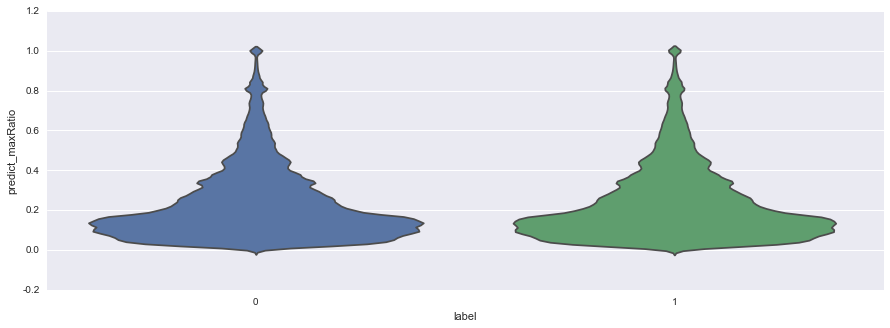

In [61]:
plt.figure(figsize=(15,5))
sns.violinplot(x="label", y="predict_maxRatio", data=df[df.predict_num>0], inner=None)

**预测词的最大概率与点击率之间似乎没有什么关系**

In [67]:
# 不同搜索词是否有可能有相同的文章推荐
print(df.groupby('title')['prefix'].nunique())
print(df.groupby('title')['prefix'].nunique().value_counts())

title
 LOVA 2010款 1.6AT格调版                                     1
! (Forward)                                              1
!我在网上买了个不绣钢饭盒                                            1
"6·26"国际禁毒日                                              2
"Del mio lungo viaggio"                                  1
"Dritthalb Jahr bin ich dein Weib"                       1
"biang"字怎么打出来                                            2
"一个人要走过多少路%2C才有资格叫做一名男子汉?"这首诗的题目是什么?                     1
"一模一样"、"模样"的读音分别是什么？                                     3
"三面红旗"风云录                                                1
"不用谢"your welcome翻译.                                     1
"久坐族"瘦肚子 每天只需五分钟 (美文版)                                   1
"人无完人"的下一句的谚语是什么?                                        2
"八项规定"图解                                                 1
"劝君更尽一杯酒，西出阳关无故人"中的"阳关"是在哪                               4
"十六字方针"是什么?                                              1
"史家之绝唱%2C无韵之离骚"理解是什么?                             

**一篇文章只对应一个搜索词前缀的占多数，少数对应更多种搜索词前缀**

In [73]:
# 对应更多搜索词的文章是否点击率更高？
tempDf = df.groupby('title')[['prefix','label']].agg({'prefix':'nunique','label':[len,'mean']})
tempDf.columns = ['%s_%s'%(x1,x2) for x1,x2 in tempDf.columns]
tempDf

label_len  label_mean  \
title                                                                       
 LOVA 2010款 1.6AT格调版                                        1    0.000000   
! (Forward)                                                 1    0.000000   
!我在网上买了个不绣钢饭盒                                               2    0.000000   
"6·26"国际禁毒日                                                 3    0.000000   
"Del mio lungo viaggio"                                     1    0.000000   
"Dritthalb Jahr bin ich dein Weib"                          1    0.000000   
"biang"字怎么打出来                                               2    0.000000   
"一个人要走过多少路%2C才有资格叫做一名男子汉?"这首诗的题目是什么?                        1    0.000000   
"一模一样"、"模样"的读音分别是什么？                                        9    1.000000   
"三面红旗"风云录                                                   1    1.000000   
"不用谢"your welcome翻译.                                        1    1.000000   
"久坐族"瘦肚子 每天只需五分钟 (美文版)                                      4    0.000000   
"人无完人"的下一句的谚语是什么?                                           4    0.750000   
"八项规定"图解                                                    1    0.000000   
"劝君更尽一杯酒，西出阳关无故人"中的"阳关"是在哪                                 24    0.750000   
"十六字方针"是什么?                                                 7    0.714286   
"史家之绝唱%2C无韵之离骚"理解是什么?                                       2    1.000000   
"唏嘘不已"是贬义词还是褒义词                                             2    0.500000   
"四价推移"理论探索                                                  3    0.000000   
"大雁听过我的歌%2C山丹丹花开花又落....一年又一年?谁听过这首歌%2C知道歌名吗?                1    0.000000   
"宝贝别哭泣%2C不是不爱你"这是什么歌?                                       1    1.000000   
"对乙酰氨基酚片"这句话的拼音                                            27    0.111111   
"帕拉天奴杯"2007作曲大赛获奖钢琴作                                        1    0.000000   
"性自由主义"是什么意思                                                1    0.000000   
"想要把你忘记真的好难"猜字谜语是什么?                                        1    1.000000   
"是故学然后知不足%2C教然后知困"%2C"困"是什么意思?学习了为什么就知道自己的不足，教别...          1    0.000000   
"枫桥经验"与新城镇社会管理创新研究                                          1    0.000000   
"枫桥经验"与法治型新农村建设                                             2    0.000000   
"桃花潭水深千尺"的下一句是什么?                                          11    0.727273   
"桨"字可以组词为"木桨"吗?                                             5    0.200000   
...                                                       ...         ...   
！新生儿吸入性肺炎2天                                                 1    0.000000   
！请问一下！哺乳期月经推迟正常吗                                            1    0.000000   
＂如果感到幸福你就拍拍手＂有这句歌词的那首歌叫什么？                                  1    1.000000   
（2-苯并咪唑基硫代）乙酸                                               1    0.000000   
（2014年秋季）特级教案 与课时作业新                                        1    0.000000   
（二）电子琴独奏-钟表                                                 2    0.000000   
（五四）语文五年级上册                                                 2    0.000000   
（合唱）他诚然担当我们的忧患                                              1    0.000000   
（女高音）我知道我的救赎主活着                                             1    0.000000   
（希舒美）阿奇霉素                                                   2    0.500000   
（幻肢）是什么意思？                                                  1    0.000000   
（扬眉吐气）猜一生肖？                                                 1    0.000000   
（教材）铁路运输组织学                                                 1    0.000000   
（特价书）认识你真好                                                  1    0.000000   
（郝智）巴氯芬片                                                    1    0.000000   
（钛锗）是什么意思啊                                                  1    1.000000   
，今天36选7开什么号码                                                3    0.000000   
，化学聚乙烯与聚氯乙烯塑料都不可降解吗                                         1    0.000000   
，孕妇可以吃螃蟹吗？                                                  2    0.000000   
，小孩不爱吃饭怎么办                                      

In [76]:
print(tempDf.groupby(('prefix_nunique'))[['label_len','label_mean']].agg({'label_len':'sum', 'label_mean':[len,'mean']}))

               label_mean           label_len
                      len      mean       sum
prefix_nunique                               
1                214883.0  0.366322    784174
2                 28403.0  0.428631    448144
3                  5351.0  0.452009    223565
4                  1325.0  0.447422    112454
5                   448.0  0.437456     55835
6                   185.0  0.415879     34387
7                    86.0  0.402966     30572
8                    62.0  0.316039     20263
9                    39.0  0.279888     15631
10                   26.0  0.272271     12329
11                   25.0  0.257445     40117
12                   25.0  0.219381      5350
13                   14.0  0.186426      3063
14                   16.0  0.343190      4578
15                   19.0  0.334448      8176
16                    7.0  0.293891      6112
17                   12.0  0.142704      2857
18                    9.0  0.124621      1989
19                   10.0  0.17674

**当对应的搜索词种类统计数小于7时，对应多个搜索词的文章点击率明显更高。之后随着统计数增大点击率逐渐下滑，但波动也更大**

In [80]:
print('搜索词前缀独立统计数',df.prefix.nunique())
print('标题的独立统计数',df.title.nunique())

print('搜索词前缀+标题的独立统计数',len(df[['prefix','title']].drop_duplicates()))
print('搜索词前缀+标签的独立统计数',len(df[['prefix','tag']].drop_duplicates()))

print('搜索词+标题的独立统计数统计:\n', df.groupby(['prefix','title'])['label'].agg([len,'mean']))
print('搜索词+标签的独立统计数统计:\n', df.groupby(['prefix','tag'])['label'].agg([len,'mean']))

print('一个文章对应多少种标签？\n',df.groupby('title')['tag'].nunique().value_counts())

搜索词前缀独立统计数 157083
标题的独立统计数 251166
搜索词前缀+标题的独立统计数 314683
搜索词前缀+标签的独立统计数 256589
搜索词+标题的独立统计数统计:
                                len      mean
prefix title                                
#      #3                       14  0.357143
       #5                       14  0.285714
       #WYD                     13  0.307692
%      %                        16  0.312500
       1%                       11  0.545455
       2%                        1  1.000000
       3%                        5  0.200000
&      &gt;                      8  0.250000
       G&S                       1  1.000000
       H&U                       2  1.000000
       M&A                       2  0.500000
       M&S                       1  0.000000
(女人    여인의 향기 (女人的香气)            1  1.000000
*p++   *p++和*(p++)有什么区别？？        1  0.000000
-      ---+-                     1  1.000000
.      ...3                     90  0.222222
       .NET安全揭秘                 89  0.247191
       .net教程                    1  0.000000
     

In [83]:
# 对应多个标签的文章点击率
tempDf = df.groupby('title')[['tag','label']].agg({'tag':'nunique', 'label':[len,'mean']})
tempDf.columns = ['%s_%s'%(x1,x2) for x1,x2 in tempDf.columns]
tempDf

tag_nunique  label_len  \
title                                                                        
 LOVA 2010款 1.6AT格调版                                          1          1   
! (Forward)                                                   1          1   
!我在网上买了个不绣钢饭盒                                                 1          2   
"6·26"国际禁毒日                                                   1          3   
"Del mio lungo viaggio"                                       1          1   
"Dritthalb Jahr bin ich dein Weib"                            1          1   
"biang"字怎么打出来                                                 1          2   
"一个人要走过多少路%2C才有资格叫做一名男子汉?"这首诗的题目是什么?                          1          1   
"一模一样"、"模样"的读音分别是什么？                                          1          9   
"三面红旗"风云录                                                     1          1   
"不用谢"your welcome翻译.                                          1          1   
"久坐族"瘦肚子 每天只需五分钟 (美文版)                                        1          4   
"人无完人"的下一句的谚语是什么?                                             1          4   
"八项规定"图解                                                      1          1   
"劝君更尽一杯酒，西出阳关无故人"中的"阳关"是在哪                                    1         24   
"十六字方针"是什么?                                                   1          7   
"史家之绝唱%2C无韵之离骚"理解是什么?                                         1          2   
"唏嘘不已"是贬义词还是褒义词                                               1          2   
"四价推移"理论探索                                                    1          3   
"大雁听过我的歌%2C山丹丹花开花又落....一年又一年?谁听过这首歌%2C知道歌名吗?                  1          1   
"宝贝别哭泣%2C不是不爱你"这是什么歌?                                         1          1   
"对乙酰氨基酚片"这句话的拼音                                               1         27   
"帕拉天奴杯"2007作曲大赛获奖钢琴作                                          1          1   
"性自由主义"是什么意思                                                  1          1   
"想要把你忘记真的好难"猜字谜语是什么?                                          1          1   
"是故学然后知不足%2C教然后知困"%2C"困"是什么意思?学习了为什么就知道自己的不足，教别...            1          1   
"枫桥经验"与新城镇社会管理创新研究                                            1          1   
"枫桥经验"与法治型新农村建设                                               1          2   
"桃花潭水深千尺"的下一句是什么?                                             1         11   
"桨"字可以组词为"木桨"吗?                                               1          5   
...                                                         ...        ...   
！新生儿吸入性肺炎2天                                                   1          1   
！请问一下！哺乳期月经推迟正常吗                                              1          1   
＂如果感到幸福你就拍拍手＂有这句歌词的那首歌叫什么？                                    1          1   
（2-苯并咪唑基硫代）乙酸                                                 1          1   
（2014年秋季）特级教案 与课时作业新                                          1          1   
（二）电子琴独奏-钟表                                                   1          2   
（五四）语文五年级上册                                                   1          2   
（合唱）他诚然担当我们的忧患                                                1          1   
（女高音）我知道我的救赎主活着                                               1          1   
（希舒美）阿奇霉素                                                     1          2   
（幻肢）是什么意思？                                                    1          1   
（扬眉吐气）猜一生肖？                                                   1          1   
（教材）铁路运输组织学                                                   1          1   
（特价书）认识你真好                                                    1          1   
（郝智）巴氯芬片                                                      1          1   
（钛锗）是什么意思啊                                                    1          1   
，今天36选7开什么号码                                                  1          3   
，化学聚乙烯与聚氯乙烯塑料都不可降解吗                                           1          1   
，孕妇可以吃螃蟹吗？                                                    1          2

In [85]:
print(tempDf.groupby('tag_nunique')['label_mean'].agg([len,'mean']))

                  len      mean
tag_nunique                    
1            238483.0  0.372379
2             11566.0  0.439577
3              1052.0  0.390070
4                61.0  0.379701
5                 3.0  0.307697
6                 1.0  0.359396


**文章的标签个数似乎也对点击率有提升作用，这个影响在标签数小于4时比较明显**

In [91]:
tempDf = df.groupby('prefix')['tag','label'].agg({'tag':'nunique', 'label':[len,'mean']})
tempDf.columns = ['%s_%s'%(x1,x2) for x1,x2 in tempDf.columns]
print(tempDf)
print(tempDf.groupby('tag_nunique')['label_mean'].agg(['mean',len]))

         tag_nunique  label_len  label_mean
prefix                                     
#                  2         41    0.317073
%                  1         33    0.393939
&                  2         14    0.428571
(女人                1          1    1.000000
*p++               1          1    0.000000
-                  1          1    1.000000
.                  5        815    0.353374
.                  2          9    0.333333
...b               2          2    0.500000
.b                 2          4    0.000000
.cn                1          4    0.750000
.com               1          3    0.333333
.comp              1          1    0.000000
.e                 1          2    0.500000
.i                 1          2    0.500000
.m.                1          5    0.400000
.mp3               2          2    0.500000
.n                 2          4    0.500000
.net               4          7    0.285714
.net框架             1          1    0.000000
.o                 1          1 

In [29]:
print(df['title'].drop_duplicates().sort_values().values.tolist())

[' LOVA 2010款 1.6AT格调版', '! (Forward)', '!我在网上买了个不绣钢饭盒', '"6·26"国际禁毒日', '"Del mio lungo viaggio"', '"Dritthalb Jahr bin ich dein Weib"', '"biang"字怎么打出来', '"一个人要走过多少路%2C才有资格叫做一名男子汉?"这首诗的题目是什么?', '"一模一样"、"模样"的读音分别是什么？', '"三面红旗"风云录', '"不用谢"your welcome翻译.', '"久坐族"瘦肚子 每天只需五分钟 (美文版)', '"人无完人"的下一句的谚语是什么?', '"八项规定"图解', '"劝君更尽一杯酒，西出阳关无故人"中的"阳关"是在哪', '"十六字方针"是什么?', '"史家之绝唱%2C无韵之离骚"理解是什么?', '"唏嘘不已"是贬义词还是褒义词', '"四价推移"理论探索', '"大雁听过我的歌%2C山丹丹花开花又落....一年又一年?谁听过这首歌%2C知道歌名吗?', '"宝贝别哭泣%2C不是不爱你"这是什么歌?', '"对乙酰氨基酚片"这句话的拼音', '"帕拉天奴杯"2007作曲大赛获奖钢琴作', '"性自由主义"是什么意思', '"想要把你忘记真的好难"猜字谜语是什么?', '"是故学然后知不足%2C教然后知困"%2C"困"是什么意思?学习了为什么就知道自己的不足，教别人怎么就会“', '"枫桥经验"与新城镇社会管理创新研究', '"枫桥经验"与法治型新农村建设', '"桃花潭水深千尺"的下一句是什么?', '"桨"字可以组词为"木桨"吗?', '"梦想号"黄包车 (纯音乐)', '"氽"字怎么读？', '"泡沫"中沸腾的《秦腔》', '"牛头不对马嘴"这句话是什么意思？', '"知识青年都到农村去" 是哪首歌的歌词', '"社会主义核心价值观"宣传广告词', '"糅"这字怎么读?是什么意思?', '"超人"妈妈成长记', '"铁路运输组织"国家级精品课程系列教材:', '"风尘三侠"-红拂女与红胡子大叔 (DJ长音频)', '#3', '#5', '#TWICE', '#ThatGirl', '#ThatGirl (Metal Boyband)', '#WYD', '#include <stdio.h>', '

In [4]:
# 观察搜索词、标题、点击情况
df[['prefix','title','label']]

prefix                     title  label
0            小品                        小品      0
1          1368           HCG大于1368%2C正常吗      0
2          1368                     1368年      1
3            银耳                  银耳红枣汤的做法      1
4          月经量少                  月经量少怎么调理      0
5        168.1.               192.168.1.1      1
6          有道翻译                    网易有道词典      0
7            生日                  生日祝福语（一）      0
8        168.1.        192.168.1.1路由器设置流程      1
9            西江                  西江千户苗寨景区      0
10       齐鲁工业大学                齐鲁工业大学菏泽校区      0
11           眉毛                 初学者怎么画好眉毛      1
12           胶质                       胶质瘤      0
13         18年运  属鼠人2018年运势 2018年属鼠人的全年运程      0
14         18年运         苏珊米勒天秤座2018年运势完整版      0
15         1944              筛查临界风险值是1944      0
16           仙草                    仙草冻的做法      0
17         德国民法               德国民法典债法总则评注      0
18          赶集网                       赶集网      0
19         200个                  200个育儿细节      0
20         202路                  长沙公交202路      0
21         202路               重庆202路公交车路线      0
22          一米阅                      一米阅读      1
23          360                   360手机助手      1
24         2060                    相见2060      0
25           猴儿                       猴儿酒      0
26           刘强                       刘强东      1
27         30公分             术后背部疤痕大约30公分长      0
28            饿                       饿了么      1
29           微记                       微记账      1
...         ...                       ...    ...
1999970      魔道                      魔道祖师      0
1999971    周公解梦                      周公解梦      0
1999972      孙红                     孙红雷新闻      0
1999973       邮                qq邮箱格式怎么写？      0
1999974       尿                       尿酸高      0
1999975     动平衡             有没有土办法解决风叶动平衡      0
1999976   梦见捡东西                      灵机八字      0
1999977   优酷app                       爱奇艺      0
1999978      秋季                 秋季滋润清汤的做法      1
1999979    梦见老虎          多梦，梦见老虎追，梦里和老虎打斗      1
1999980    梦见老虎          多梦，梦见老虎追，梦里和老虎打斗      1
1999981      卡西                     卡西欧官网      1
1999982    梦见老虎          多梦，梦见老虎追，梦里和老虎打斗      0
1999983    梦见老虎           梦见老虎从笼子里出来什么意思啊      1
1999984    梦见老虎          多梦，梦见老虎追，梦里和老虎打斗      1
1999985      猴头                  猴头菇炖鸡的做法      0
1999986      云烟                      云烟成雨      0
1999987      排骨                  玉米排骨汤的做法      0
1999988      汽车                      汽车之家      1
1999989   梦见自己死              我梦见自己死了变成了灵魂      0
1999990      莫高                     莫高窟记忆      0
1999991   梦见自己死              我梦见自己死了变成了灵魂      0
1999992   梦见自己死            梦见自己死了但是感觉还是活着      1
1999993   梦见自己死                    梦见自己死了      0
1999994   梦见自己死                    梦见自己死了      0
1999995   内蒙古民族                 内蒙古民族大学官网      1
1999996     药膳鸡                    药膳鸡的做法      1
1999997   棕榈泉花园                     棕榈泉花园      1
1999998    时间飞行                时间飞行 (古风版)      0
1999999    运动神经                 老年人运动神经元病      1

[2000000 rows x 3 columns]

In [8]:
# 未出现搜索词的标题的点击情况
startTime = datetime.now()
df['prefix_in_title'] = df[['prefix','title']].dropna().apply(lambda x: x.title.find(x.prefix), axis=1)
print('cost time:', datetime.now() - startTime)
print(df[df.prefix_in_title < 0][['prefix','title','label']])

cost time: 0:01:02.823084
           prefix          title  label
6            有道翻译         网易有道词典      0
31          360管家      速贷360分期贷款      0
32          360管家        360清理大师      1
33          360管家         8868租号      0
46           3d走势     帝国时代（即时战略）      0
49           3d走势     帝国时代（即时战略）      0
51           3d走势   修仙无双（脱单仙侠游戏）      0
83       ipad pro  iPad Pro是什么系统      0
92             滴滴           嘀嗒出行      0
103       4399游戏盒           三国战纪      0
106       4399游戏盒           三国战纪      1
118            高德           百度地图      0
119       4399游戏盒        2345浏览器      0
145       4399游戏盒        2345浏览器      0
171       4399游戏盒           三国战纪      0
178            借了        老哥帮小额借款      0
179           大众辉         汽车报价大全      0
234            微商          青团社兼职      0
245            uu           UU跑腿      0
251       4399游戏盒           三国战纪      0
254            探探         MOMO陌陌      0
256          滴滴快车          优信二手车      0
306          玛莎拉蒂         汽车报价大全      0
313           

In [9]:
print(len(df[(df.prefix_in_title<0)]))
print(df[(df.prefix_in_title<0)&(df.label==1)][['prefix','title','label']])

148580
           prefix            title  label
32          360管家          360清理大师      1
106       4399游戏盒             三国战纪      1
464         OPPO              OPPO      1
472         OPPO              OPPO      1
477         OPPO              OPPO      1
480         OPPO              OPPO      1
481         OPPO              OPPO      1
484         OPPO              OPPO      1
486         OPPO              OPPO      1
487         OPPO              OPPO      1
492         OPPO              OPPO      1
496         OPPO              OPPO      1
498         OPPO              OPPO      1
502         OPPO              OPPO      1
505         OPPO              OPPO      1
510         OPPO              OPPO      1
525         OPPO              OPPO      1
531         OPPO              OPPO      1
540         OPPO              OPPO      1
542         OPPO              OPPO      1
544         OPPO              OPPO      1
546         OPPO              OPPO      1
551         OPPO           

**看来统计时最好统一英文大小写**

In [11]:
# 重新统一完大小写并去首位空格再统计
startTime = datetime.now()
df['prefix_upper'] = df['prefix'].dropna().map(lambda x: x.upper())
df['title_upper'] = df['title'].dropna().map(lambda x: x.upper())
df['prefix_in_title'] = df[['prefix_upper','title_upper']].dropna().apply(lambda x: x.title_upper.find(x.prefix_upper.strip()), axis=1)
print('cost time:', datetime.now() - startTime)
print(len(df[df.prefix_in_title < 0]))
print(df[(df.prefix_in_title < 0)&(df.label==1)][['prefix_upper','title_upper','label']])

cost time: 0:01:05.078377
111048
        prefix_upper      title_upper  label
32             360管家          360清理大师      1
106          4399游戏盒             三国战纪      1
579               阜新              百姓网      1
1127              QA            百度输入法      1
1132              QA            QQ浏览器      1
1134              QA           360浏览器      1
1167             高铁票     高铁管家12306火车票      1
1181              住房           公积金查询网      1
1189       SOGOU.COM           搜狗搜索官网      1
1314       WWW.CHINA          中国志愿服务网      1
1319       WWW.CHINA          中国志愿服务网      1
1321       WWW.CHINA          中国志愿服务网      1
1324       WWW.CHINA          中国志愿服务网      1
1325       WWW.CHINA          中国志愿服务网      1
1329       WWW.CHINA          中国志愿服务网      1
1337       WWW.CHINA          中国志愿服务网      1
1339       WWW.CHINA          中国志愿服务网      1
1348       WWW.CHINA          中国志愿服务网      1
1350       WWW.CHINA          中国志愿服务网      1
1604              爱车           汽车报价大全      1
1641             LOL  

**这下区分度就明显很多了，不包含搜索词的title，点击率明显偏低。而且其中还有不少其实是包含了部分词，这些在通过分词后可以解决。剩余的问题是同义词或者同一主题词，这部分后期再研究如何处理**

In [30]:
# 调查搜索词和标题的长度
df['prefix_len'] = df['prefix'].dropna().map(lambda x: len(x))
df['title_len'] = df['title'].dropna().map(lambda x: len(x))
print(df[['prefix_len','title_len']].describe())

         prefix_len     title_len
count  1.999996e+06  2.000000e+06
mean   2.711129e+00  6.305635e+00
std    1.237819e+00  4.162865e+00
min    1.000000e+00  1.000000e+00
25%    2.000000e+00  4.000000e+00
50%    2.000000e+00  5.000000e+00
75%    3.000000e+00  8.000000e+00
max    2.000000e+01  1.370000e+02


In [17]:
print(df[df.prefix_len>7]['prefix'])
print(df[df.title_len>20]['title'])

60                 十一酸睾酮注射液
83                 ipad pro
107                史上最坑爹的游戏
297                中通快递单号查询
706        are you sleeping
750               break up 
868                favorite
872                favorite
873                favorite
894               good time
973                mirror m
1087              坐月子吃什么水果好
1105               火疗真的能治病吗
1187              sogou.com
1188              sogou.com
1189              sogou.com
1197               super ju
1202               tfboys之时
1203               tfboys之时
1295              win10定时关机
1314              www.china
1315              www.china
1317              www.china
1319              www.china
1321              www.china
1322              www.china
1324              www.china
1325              www.china
1329              www.china
1330              www.china
                 ...       
1984672            孕妇血压高怎么办
1985936            经期能吃三七粉吗
1986293            宁夏人事考试中心
1988269            一日不见如隔三秋
1988740           维生

In [19]:
# 探索预测词
df['query_list'] = df['query_prediction'].dropna().map(lambda x: list(eval(x).keys()))
print(df[['prefix','query_list']])

         prefix                                         query_list
0            小品  [小品大全宋小宝, 小品相亲, 小品不差钱, 小品视频, 小品搞笑大全剧本, 小品搞笑大全,...
1          1368  [13685367892, 13688cc, 13689557333.com, 1368个单...
2          1368  [13685367892, 13688cc, 13689557333.com, 1368个单...
3            银耳  [银耳莲子汤, 银耳为什么不能天天吃, 银耳汤的功效, 银耳的做法大全, 银耳的做法, 银耳...
4          月经量少  [月经量少怎么, 月经量少该怎么调理, 月经量少怎么办, 月经量少吃什么, 月经量少怎么调理...
5        168.1.  [168.1.1, 168.1.1路由器设置, 168.1.0, 168.1.1路由器修改密...
6          有道翻译  [有道翻译官在线翻译, 有道翻译在线翻译英语, 有道翻译官下载安装, 有道翻译在线发音, 有...
7            生日  [生日祝福, 生日快乐, 生日快乐祝福语, 生日快乐英文, 生日蛋糕, 生日祝福语, 生日蛋...
8        168.1.  [168.1.1, 168.1.1路由器设置, 168.1.0, 168.1.1路由器修改密...
9            西江  [西江苗寨, 西江千户苗寨门票, 西江月, 西江月井冈山, 西江千户苗寨, 西江月夜行黄沙道...
10       齐鲁工业大学  [齐鲁工业大学录取查询, 齐鲁工业大学贴吧, 齐鲁工业大学是几本, 齐鲁工业大学宿舍, 齐鲁...
11           眉毛  [眉毛的种类, 眉毛怎么画, 眉毛纹绣价格, 眉毛图片, 眉毛长痘痘, 眉毛长痘, 眉毛价格...
12           胶质  [胶质瘤最后怎样死亡, 胶质瘤四级15年不复发, 胶质瘤是怎样形成的, 胶质瘤能活多久, 胶...
13         18年运                                     [18年运程, 18

In [21]:
# 探索预测词的最大字数
df['query_maxLen'] = df['query_list'].dropna().map(lambda x: max([len(v) for v in x]) if len(x)>0 else 0)
print(df['query_maxLen'].describe())

count    2.000000e+06
mean     9.619920e+00
std      1.775848e+00
min      0.000000e+00
25%      9.000000e+00
50%      1.000000e+01
75%      1.000000e+01
max      3.000000e+01
Name: query_maxLen, dtype: float64


In [41]:
import jieba
# print(" ".join(jieba.cut("192.168怎么打开？有人，还有,英文", cut_all=True)))
jieba.add_word("唐家三少")
jieba.suggest_freq("斗罗大陆",True)
temp = jieba.cut_for_search("刘强，刘强东192.168怎么打开？有人，还  有,英文,唐家三少斗罗大陆#")
print("|".join(temp))

刘强|，|刘强东|192.168|怎么|打开|？|有人|，|还| | |有|,|英文|,|唐家三少|大陆|斗罗大陆|#


In [15]:
import jieba
from gensim.models import Word2Vec
tempDf = df[['title']].head(30)
tempDf['title_cut'] = tempDf['title'].map(lambda x: list(jieba.cut(x.lower())))
tempDf = tempDf.iloc[[0,2,3,4,6,9,11,16]]
print(tempDf)

model = Word2Vec(tempDf['title_cut'].values, window=5, min_count=1)
print(model.similarity('银耳', '仙草'))
print(model.similarity('银耳', '做法'))
print(model['银耳'])
print(model.most_similar('银耳'))

        title          title_cut
0          小品               [小品]
2       1368年          [1368, 年]
3    银耳红枣汤的做法   [银耳, 红枣汤, 的, 做法]
4    月经量少怎么调理   [月经, 量少, 怎么, 调理]
6      网易有道词典       [网易, 有道, 词典]
9    西江千户苗寨景区   [西江, 千户, 苗寨, 景区]
11  初学者怎么画好眉毛  [初学者, 怎么, 画好, 眉毛]
16     仙草冻的做法     [仙草, 冻, 的, 做法]
0.048953
0.113817
[ -1.88916852e-03  -3.78654734e-03   4.82765213e-03  -4.51509957e-04
   4.95882845e-03   4.31827549e-03  -4.61690826e-03   2.08435720e-03
  -9.48305242e-04   3.89503432e-03  -4.53052955e-04   3.96964792e-03
   1.22871925e-03   2.60349293e-03   2.54860800e-03  -3.18958308e-03
  -4.90911864e-03   1.83016027e-03   1.66719826e-03  -2.43511749e-03
   1.33777177e-03  -4.57420107e-03   1.22650899e-03  -4.66487696e-03
  -2.32942821e-03   1.46108423e-03  -4.37122257e-03   4.95816628e-03
  -1.64753280e-03  -8.90678057e-05  -5.97029459e-04   9.48994653e-04
   5.72312973e-04  -5.76156308e-04   4.45755944e-03  -4.79422044e-03
   2.28103902e-03  -1.02921564e-03   1.36252400e-03  -6.61533733

D:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel\__main__.py:9: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
D:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel\__main__.py:10: DeprecationWarning: Call to deprecated `similarity` (Method will be removed in 4.0.0, use self.wv.similarity() instead).
D:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel\__main__.py:11: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
D:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel\__main__.py:12: DeprecationWarning: Call to deprecated `most_similar` (Method will be removed in 4.0.0, use self.wv.most_similar() instead).
